In [1]:
from __future__ import absolute_import, division, print_function
from matplotlib.font_manager import _rebuild; _rebuild()
#Helper libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.io as spio
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils
from sklearn.model_selection import KFold, cross_val_score, GridSearchCV, train_test_split, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import precision_recall_fscore_support, roc_curve, auc
from sklearn.preprocessing import LabelEncoder, LabelBinarizer, StandardScaler
from yellowbrick.classifier import ROCAUC, PrecisionRecallCurve
from yellowbrick.model_selection import LearningCurve
import random
import sys

Using Theano backend.
WARNING (theano.configdefaults): install mkl with `conda install mkl-service`: No module named 'mkl'


In [2]:
# Save all output to file.
sys.stdout = open("graph_logging.txt","w")
sys.stdout.flush()

# Initialize random number generator for reproducibility.
seed = 7
np.random.seed(seed)

# Load in dataset.
data = spio.loadmat("features_10s_2019-01-30.mat");
features = data['features'];
labels = data['labels_features'];
animal_id_features = data['animal_id_features'].transpose();
animal_names = data['animal_names'].transpose();
feat_names = data['feat_names'];
col_names = pd.DataFrame(feat_names)

# Label each feature column with its description.
def find_between(s):
    start = '\'';
    end = '\'';
    return((s.split(start))[1].split(end)[0])
cols = [];
c_names = col_names.values.ravel();

for x in range(len(c_names)):
    name = str (c_names[x]);
    cols.append(find_between(name))

# Create a DataFrame of features with columns named & rows labeled.
feat_data = pd.DataFrame(data=features,columns=cols)
feat_data.insert(0,'AnimalId',animal_id_features)
feat_data.insert(0,'Labels',labels.transpose())

# Select the features corresponding to one animal.
def get_single_animal_features(df, index) :
    return df.loc[df['AnimalId'] == index]

# Delete the rows corresponding to the animal left out.
def get_loo_features(df, index):
    df[df.AnimalId != index]
    return df

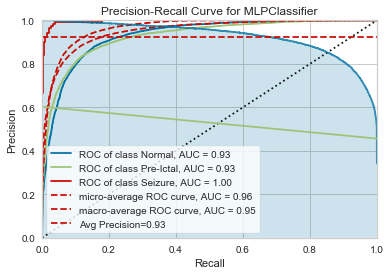

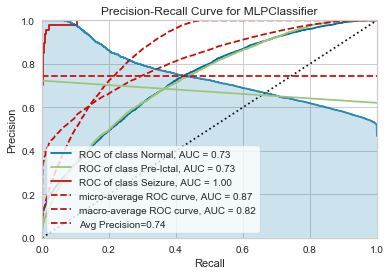

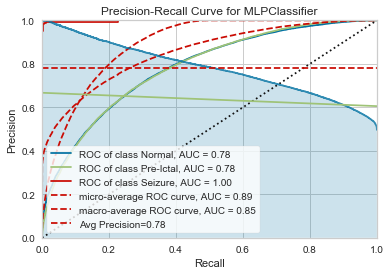

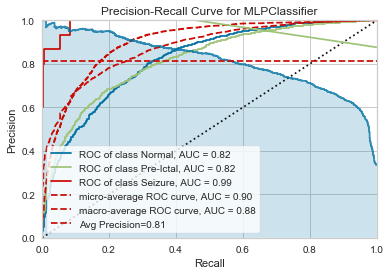

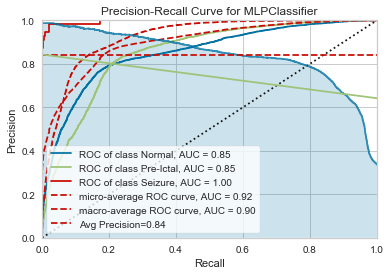

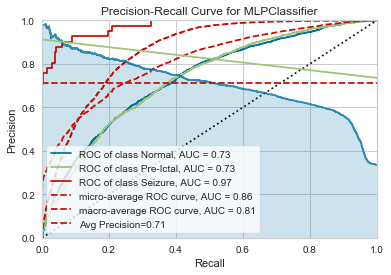

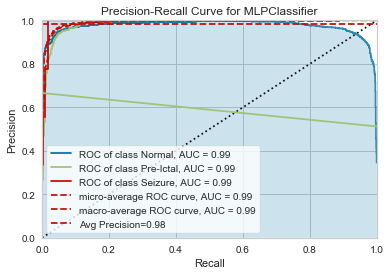

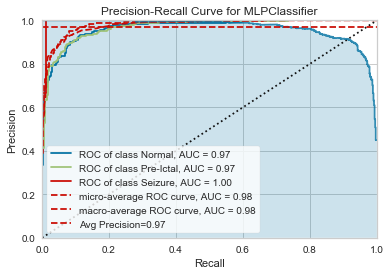

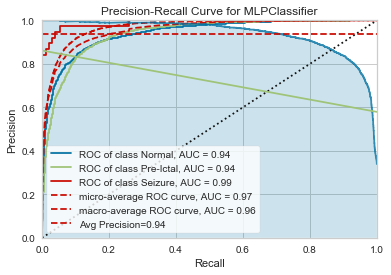

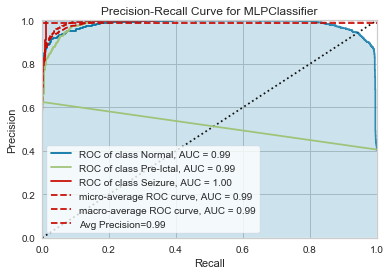

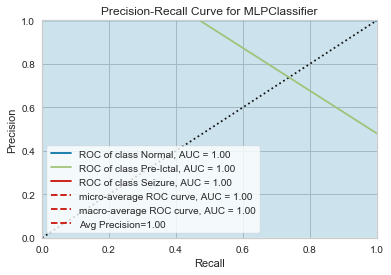

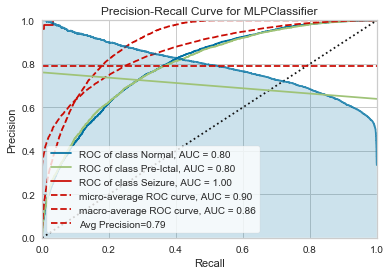

<Figure size 432x288 with 0 Axes>

In [3]:
# Produce MLPClassification for each animal in the dataset.
for i in range(1,13):
    index = i
    print("Animal chosen: %s" % animal_names[index - 1][0])
    animal_id = animal_names[index-1][0]
    # Get features of 11/12 animals.
    single_animal_features = get_single_animal_features(feat_data, index);
    # loo_features = get_loo_features(feat_data, index);

    # Get only labels corresponding to selected animal's features.
    y = single_animal_features['Labels']
    X = single_animal_features.drop(columns={'Labels','AnimalId'})

    # Split data into training (80%) and testing (20%).
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2);

    # Standardize the data since the MLP is sensitive to feature scaling.
    scaler = StandardScaler()

    # Fit only to the training data.
    scaler.fit(X_train)

    # Apply the transformations to the data.
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)

    # Initialize the model with constant iteration max = 1500 and optimal parameters (as determined by gridsearch).
    mlp = MLPClassifier(
        max_iter=1500,
        verbose=51,
        tol=0.000001, 
        learning_rate='constant',
        alpha=0.001,
        solver='adam',
        batch_size=512,
        activation='tanh')

    # Run model with 4-fold cross validation. Report mean accuracy.
#     scores = cross_val_score(mlp, X_train, y_train, cv=4)
#     print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

    # Plot ROC, AUC.
    classes=["Normal","Pre-Ictal","Seizure"]
    visualizer = ROCAUC(mlp, classes=classes)

    visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
    visualizer.score(X_test, y_test)  # Evaluate the model on the test data
    ROC_title = "ROCAUC_{}.png".format(animal_id)
    g = visualizer.poof(outpath=ROC_title) # Save plot w unique title

    # Plot the precision-recall curve.
    viz = PrecisionRecallCurve(mlp) 
    viz.fit(X_train, y_train) # Fit the training data to the visualizer
    viz.score(X_test, y_test) # Evaluate the model on the test data
    PR_title = "PR_{}.png".format(animal_id)
    viz.poof(outpath=PR_title) # Save plot w unique title

    # Plot loss curve aka cost function.
    loss_values = mlp.loss_curve_
    plt.plot(loss_values)
    plt.show()
    Loss_title = "Loss_{}.png".format(animal_id)
    plt.savefig(Loss_title)
    

In [ ]:
sys.stdout.close()